In [52]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import csv
import os
from scipy.optimize import curve_fit
import scipy.interpolate as interpolate
import scipy
from scipy.fft import fft, rfft, irfft,ifft,fftfreq
import wget,requests
from scipy.interpolate import LinearNDInterpolator


nist_table_dir="./NistData"


#### Getting isobar data from nist 

In [37]:
Pressure=1
TempHigh=300
TempLow=270
TempStep=1


for Pressure in np.arange(0.1,900.1,25):
    fname="NistData-isobar-P%0.2f-HighT%0.2f-LowT%0.2f-Step%0.2f.tsv"%(Pressure,TempHigh,TempLow,TempStep)
    filepath="./NistData/%s"%(fname)
    #print("https://webbook.nist.gov/cgi/fluid.cgi?Action=Data&Wide=on&ID=C7440633&Type=IsoBar&Digits=5&P=%0.2f&THigh=%0.2f&TLow=%0.2f&TInc=%0.2f&RefState=DEF&TUnit=K&PUnit=psia&DUnit=g%%2Fml&HUnit=kJ%%2Fmol&WUnit=m%%2Fs&VisUnit=uPa*s&STUnit=N%%2Fm"%(Pressure,TempHigh,TempLow,TempStep))
    if os.path.exists(filepath):
        print("Skipping %s, already exisis"%(filepath))
    else:
        url ="https://webbook.nist.gov/cgi/fluid.cgi?Action=Data&Wide=on&ID=C7440633&Type=IsoBar&Digits=5&P=%0.2f&THigh=%0.2f&TLow=%0.2f&TInc=%0.2f&RefState=DEF&TUnit=K&PUnit=psia&DUnit=g%%2Fml&HUnit=kJ%%2Fmol&WUnit=m%%2Fs&VisUnit=uPa*s&STUnit=N%%2Fm"%(Pressure,TempHigh,TempLow,TempStep)
        file=wget.download(url,filepath )

Skipping ./NistData/NistData-isobar-P0.10-HighT300.00-LowT270.00-Step1.00.tsv, already exisis
Skipping ./NistData/NistData-isobar-P25.10-HighT300.00-LowT270.00-Step1.00.tsv, already exisis
Skipping ./NistData/NistData-isobar-P50.10-HighT300.00-LowT270.00-Step1.00.tsv, already exisis
Skipping ./NistData/NistData-isobar-P75.10-HighT300.00-LowT270.00-Step1.00.tsv, already exisis
Skipping ./NistData/NistData-isobar-P100.10-HighT300.00-LowT270.00-Step1.00.tsv, already exisis
Skipping ./NistData/NistData-isobar-P125.10-HighT300.00-LowT270.00-Step1.00.tsv, already exisis
Skipping ./NistData/NistData-isobar-P150.10-HighT300.00-LowT270.00-Step1.00.tsv, already exisis
Skipping ./NistData/NistData-isobar-P175.10-HighT300.00-LowT270.00-Step1.00.tsv, already exisis
Skipping ./NistData/NistData-isobar-P200.10-HighT300.00-LowT270.00-Step1.00.tsv, already exisis
Skipping ./NistData/NistData-isobar-P225.10-HighT300.00-LowT270.00-Step1.00.tsv, already exisis
Skipping ./NistData/NistData-isobar-P250.10-H

In [21]:
files = glob.glob(nist_table_dir+"/*isobar-P[0-30]*LowT[161]*")
print(files)

['./NistData\\NistData-isobar-P0.10-HighT200.00-LowT161.00-Step1.00.tsv', './NistData\\NistData-isobar-P0.20-HighT200.00-LowT161.00-Step1.00.tsv', './NistData\\NistData-isobar-P0.30-HighT200.00-LowT161.00-Step1.00.tsv', './NistData\\NistData-isobar-P0.40-HighT200.00-LowT161.00-Step1.00.tsv', './NistData\\NistData-isobar-P0.50-HighT200.00-LowT161.00-Step1.00.tsv', './NistData\\NistData-isobar-P0.60-HighT200.00-LowT161.00-Step1.00.tsv', './NistData\\NistData-isobar-P0.70-HighT200.00-LowT161.00-Step1.00.tsv', './NistData\\NistData-isobar-P0.80-HighT200.00-LowT161.00-Step1.00.tsv', './NistData\\NistData-isobar-P0.90-HighT200.00-LowT161.00-Step1.00.tsv', './NistData\\NistData-isobar-P1.00-HighT200.00-LowT161.00-Step1.00.tsv', './NistData\\NistData-isobar-P1.10-HighT200.00-LowT161.00-Step1.00.tsv', './NistData\\NistData-isobar-P1.20-HighT200.00-LowT161.00-Step1.00.tsv', './NistData\\NistData-isobar-P1.30-HighT200.00-LowT161.00-Step1.00.tsv', './NistData\\NistData-isobar-P1.40-HighT200.00-Low

### Isobar

#### Read in isobar data to XeTable for Cell

In [22]:
files = glob.glob(nist_table_dir+"/*isobar-P[0-30]*LowT[161]*")
DFs=[]
Ps=[]
Ts=[]
Ds=[]
for file in files:
    DF= pd.read_table(file)
    DFs.append(DF)
    Ps.append(DF["Pressure (psia)"][:].values)
    Ts.append(DF["Temperature (K)"][:].values)
    Ds.append(DF["Density (g/ml)"][:].values)


XeTable=pd.concat(DFs,ignore_index=True)
XeTable = XeTable.sort_values(by=["Pressure (psia)","Temperature (K)"])


#### Set up 2d interpolation

In [28]:
X=np.array(XeTable["Temperature (K)"])
Y=np.array(XeTable["Pressure (psia)"])
Z=np.array(XeTable["Density (g/ml)"])
IsoBar_TvP=LinearNDInterpolator(list(zip(X,Y)),Z)

#### colorbar map of density for PvT  cmap is log scale

abs(`Temperature (K)` -172.500000) <12.500000 and abs(`Pressure (psia)` - 20.500000) <7.537688
165.65514928211525 21.011622306471303 2.938182014738039
170.25261476527842 18.014240639971046 0.011940102089888304
182.55249439461764 23.49684259064409 0.01455215476249663
165.82536874683294 19.228622226177045 2.936975492521536
164.0391912134009 13.502094074822148 0.009233090211686617
170.6418303955526 16.68762789420183 0.011001895179577458


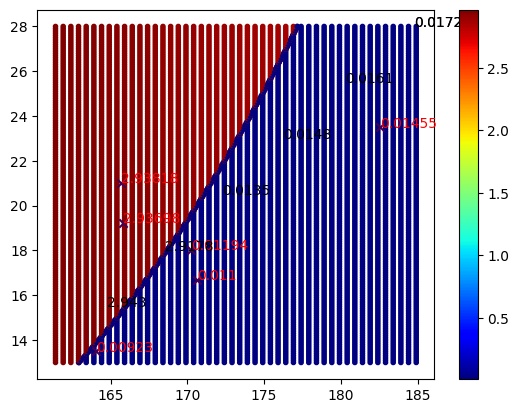

In [ ]:
Tmin=160
Tmax=185
Pmin=13
Pmax=28
count=5

print("abs(`Temperature (K)` -%f) <%f and abs(`Pressure (psia)` - %f) <%f"%((Tmin+Tmax)/2, (Tmax-Tmin)/2,(Pmax+Pmin)/2,(Pmax-Pmin)/1.99))
DF=XeTable.query("abs(`Temperature (K)` -%f) <%f and abs(`Pressure (psia)` - %f) <%f"%((Tmin+Tmax)/2, (Tmax-Tmin)/2,(Pmax+Pmin)/2,(Pmax-Pmin)/1.99))

plt.scatter(DF["Temperature (K)"],DF["Pressure (psia)"],c=(DF["Density (g/ml)"]),marker=".",cmap="jet")
plt.colorbar()


for i in np.arange(0,count+1,1):
    x=np.random.random()*(Tmax-Tmin)+Tmin
    y=np.random.random()*(Pmax-Pmin)+Pmin
    z=IsoBar_TvP(x,y)
    print(x,y,z)

    plt.text(x,y,np.round(z,5),color="red")
    plt.scatter(x,y,c=z,marker="x")


for m in [0,1,2,3,4,5,6]:
    m= int(m/6* len(DF.index)) -1
    X=DF["Temperature (K)"].iloc[m]
    Y=DF["Pressure (psia)"].iloc[m]
    Z=DF["Density (g/ml)"].iloc[m]
    plt.text(X-0.15,Y-0.015,np.round(Z,4))
    




In [ ]:
IsoBar_TvP(293,525)

array(nan)

#### Read in isobar data to XeTable for Storage

In [53]:
files = glob.glob(nist_table_dir+"/*isobar*LowT[270]*")
DFs=[]
Ps=[]
Ts=[]
Ds=[]
for file in files:
    DF= pd.read_table(file)
    DFs.append(DF)
    Ps.append(DF["Pressure (psia)"][:].values)
    Ts.append(DF["Temperature (K)"][:].values)
    Ds.append(DF["Density (g/ml)"][:].values)


XeTable_storage=pd.concat(DFs,ignore_index=True)
XeTable_storage = XeTable_storage.sort_values(by=["Pressure (psia)","Temperature (K)"])


In [54]:
X=np.array(XeTable_storage["Temperature (K)"])
Y=np.array(XeTable_storage["Pressure (psia)"])
Z=np.array(XeTable_storage["Density (g/ml)"])
IsoBar_TvP_storage=LinearNDInterpolator(list(zip(X,Y)),Z)

abs(`Temperature (K)` -295.000000) <5.000000 and abs(`Pressure (psia)` - 637.500000) <-113.065327


IndexError: single positional indexer is out-of-bounds

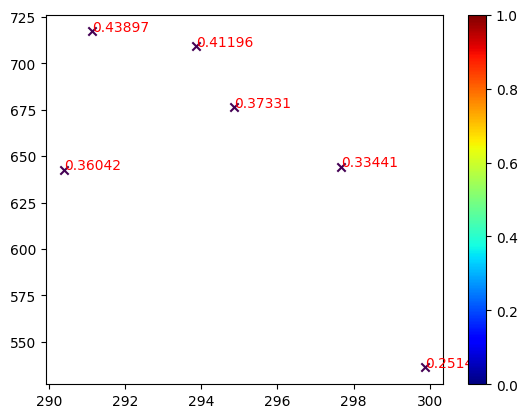

In [55]:
Tmin=290
Tmax=300
Pmin=750
Pmax=525
count=5

Storage_vol=7570.82 +300## Storage volume in ml

print("abs(`Temperature (K)` -%f) <%f and abs(`Pressure (psia)` - %f) <%f"%((Tmin+Tmax)/2, (Tmax-Tmin)/2,(Pmax+Pmin)/2,(Pmax-Pmin)/1.99))
DF=XeTable_storage.query("abs(`Temperature (K)` -%f) <%f and abs(`Pressure (psia)` - %f) <%f"%((Tmin+Tmax)/2, (Tmax-Tmin)/2,(Pmax+Pmin)/2,(Pmax-Pmin)/1.99))

plt.scatter(DF["Temperature (K)"],DF["Pressure (psia)"],c=(DF["Density (g/ml)"]),marker=".",cmap="jet")
plt.colorbar()


for i in np.arange(0,count+1,1):
    x=np.random.random()*(Tmax-Tmin)+Tmin
    y=np.random.random()*(Pmax-Pmin)+Pmin
    z=IsoBar_TvP_storage(x,y)
    
    
    plt.text(x,y,np.round(z,5),color="red")
    plt.scatter(x,y,c=z,marker="x")


for m in [0,1,2,3,4]:
    m= int(m/4* len(DF.index)) -1
    X=DF["Temperature (K)"].iloc[m]
    Y=DF["Pressure (psia)"].iloc[m]
    Z=DF["Density (g/ml)"].iloc[m]

    
    plt.text(X-0.5,Y-0.025,np.round(Z,4))
    




## Amount of Xenon in Storage clyinder with P and T

In [56]:
## Set the time 0 amount of xenon

x=293
y=675+14.7
z=IsoBar_TvP_storage(x,y)

print( "Xe Mass in Storage at %0.3f psia(%0.3f psig) and %0.3f K is %0.3f grams:"%(y,y-14.7,x,z*Storage_vol))

XeMass_t0=z*Storage_vol
print(XeMass_t0)

Xe Mass in Storage at 689.700 psia(675.000 psig) and 293.000 K is 3114.680 grams:
3114.6799296672


Xenon Mass in Storage as of 20240618 @ 1515 is 2076.88 grams, @ 294.65 K and 540 psig

## Amount of Xenon removed from storage.


In [80]:
x=293 #temp
y=490+14.7 #pressure
z=IsoBar_TvP_storage(x,y)

XeMass_removed= XeMass_t0 - z*Storage_vol

print( "Xe Mass in Storage at %0.3f psia(%0.3f psig) and %0.3f K is %0.3f grams:"%(y,y-14.7,x,z*Storage_vol))

print( "Xe Mass removed from storage at %0.3f psia(%0.3f psig) and %0.3f K is %0.3f grams:"%(y,y-14.7,x,XeMass_removed))


Xe Mass in Storage at 504.700 psia(490.000 psig) and 293.000 K is 1915.875 grams:
Xe Mass removed from storage at 504.700 psia(490.000 psig) and 293.000 K is 1198.805 grams:


## 20241004

In [81]:
mass_removed_2 = [554.6378,866,1093,1200,1400,1448,1634, 1810]
time_2 = [9 +11/60,9 +41/60, 10.0,10.5,10 + 40/60, 11 +10/60, 11.5, 12 ]  ##20241004

mass_removed = [199.3,555,684,866,1145,1200]
time = [10+23/60,10 + 37/60,10.75,11 +5/60,11.75,11+55/60]  ## 20241007

Text(0.5, 0, 'Time of Day [h]')

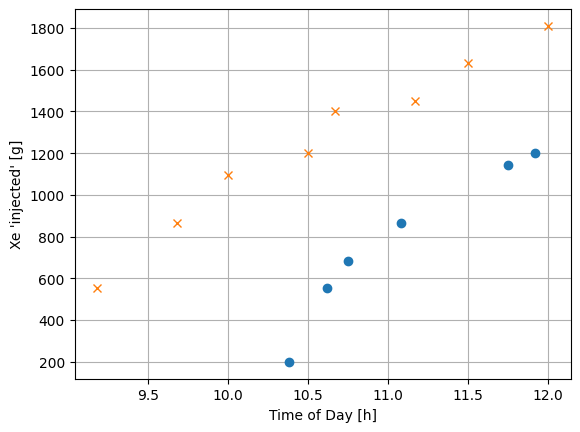

In [82]:
plt.errorbar(x=time, y=mass_removed,fmt=" ", marker="o")
plt.errorbar(x=time_2, y=mass_removed_2,fmt=" ", marker="x")

plt.grid()
plt.ylabel("Xe 'injected' [g]")
plt.xlabel("Time of Day [h]")

## Estimate Volmne of Cell

### Cupper Cell

In [53]:
Cu_Cell_H =215.9 #mm
Cu_Cell_ID=99.949  #mm
Cu_Cell_vol= Cu_Cell_H * (Cu_Cell_ID/2)**2 * np.pi
Cu_Cell_vol

1693945.4876925927

### Stainless Steal Nipple

In [54]:
SS_Nipple_H  = 134.874#mm
SS_Nipple_ID = 100#mm This is the OD 
SS_Nipple_vol= SS_Nipple_H * (SS_Nipple_ID/2)**2 * np.pi
SS_Nipple_vol

1059297.9189006744

### Cross

In [55]:
Cross_large_ID = 72.898 #mm 76.2 OD guess at ID from standard chart
Cross_large_len= 85.852*2#mm
Cross_small_ID = 60.198 #mm 63.5 OD guess at ID from standard chart
Cross_small_len= 75.184*2#mm

Cross_small_overlap_vol = Cross_large_ID * (Cross_small_ID/2)**2 * np.pi

Cross_vol = Cross_large_len * ( Cross_large_ID/2)**2 * np.pi + Cross_small_len* (Cross_small_ID/2)**2 * np.pi - Cross_small_overlap_vol
Cross_vol


937130.1069842934

### Tubing and Extras

In [56]:
Tubing_len=500 #mm rough estimate measuring tubes on top of cryo
Tubing_ID=4.572 #1/4 OD estimate of ID via standard chart

Tubing_vol=Tubing_len* (Tubing_ID/2)**2 * np.pi
Tubing_vol

8208.661161379463

### Total Vol

In [57]:
Total_Xenon_Vol= SS_Nipple_vol+ Cu_Cell_vol+Cross_vol+Tubing_vol+300000
Total_Xenon_Vol #cubim mm

print("Total xenon vol is %0.3f ml"%(Total_Xenon_Vol*0.001))

Total xenon vol is 3998.582 ml


In [58]:
#Estimate extra vol as extra heigth on cell

Extra_Vol_fakeH =(Cross_vol+Tubing_vol+300000)/(Cu_Cell_ID/2)**2 #,,

Vol_Other= (Extra_Vol_fakeH + SS_Nipple_H)*(SS_Nipple_ID/2)**2 *0.001
print(Vol_Other, " Vol other ml")


1583.7949860882256  Vol other ml


In [59]:
np.pi *((3.5/2)**2-(3/2)**2) *12 * 16.3871  #+ np.pi *((2/2)**2-(1/2)**2) *6 * 16.3871 

501.9455314930027

In [60]:
CubeVol_withhole = 3.5*3.5*12 *16.3871  - (np.pi * (0.8/2)**2 * 12 *16.3871)

ppv=CubeVol_withhole/120

print(CubeVol_withhole,ppv)

2310.0590414906087 19.250492012421738


In [61]:
CubeVol_withhole = 3.5*3.5*3.5 *16.3871  - np.pi * (0.8/2)**2 * 3.5 *16.3871

ppv=CubeVol_withhole/59

print(CubeVol_withhole,ppv)

673.7672204347609 11.419783397199337


In [62]:
np.pi*(3.75/2)**2 * 6 * 16.3871 , np.pi*(3.75/2)**2 * 6 * 16.3871/130 , 2.7*np.pi*(3.75/2)**2 * 6 * 16.3871

(1085.9398517877462, 8.353383475290356, 2932.0375998269146)

In [63]:
0.0054178*100*1000/1000

0.54178

## Density in Cell

In [72]:
mass=2850#XeMass_removed
XeCell_Density = mass/(Total_Xenon_Vol*0.001) # g/ml
XeCell_Density


0.7127526396743544

### Grab isochoric data for heigth estimate

In [70]:
XeDensity=XeCell_Density
THigh=300
TLow=161
TStep=0.25


IsoChoric_URL="https://webbook.nist.gov/cgi/fluid.cgi?Action=Data&Wide=on&ID=C7440633&Type=IsoChor&Digits=5&THigh=%0.3f&TLow=%0.3f&TInc=%0.3f&D=%0.3f&RefState=DEF&TUnit=K&PUnit=psia&DUnit=g%%2Fml&HUnit=kJ%%2Fmol&WUnit=m%%2Fs&VisUnit=uPa*s&STUnit=N%%2Fm"%(THigh,TLow,TStep,XeDensity)
IsoChoric_filename="NistData-isochoric-D%0.4f-TLow%0.3f-THigh%0.3f-Tstep%0.3f.tsv"%(XeDensity,TLow,THigh,TStep)

filepath="./NistData/%s"%(IsoChoric_filename)
if os.path.exists(filepath):
    print("Skipping %s, already exisis"%(filepath))
    file = open(filepath)
else:
    print("Getting new file with Density if %f"%(XeDensity))
    print(IsoChoric_URL)
    file=wget.download(IsoChoric_URL,filepath )

XeIsoChoric_DF = pd.read_table(file)



Getting new file with Density if 0.712753
https://webbook.nist.gov/cgi/fluid.cgi?Action=Data&Wide=on&ID=C7440633&Type=IsoChor&Digits=5&THigh=300.000&TLow=161.000&TInc=0.250&D=0.713&RefState=DEF&TUnit=K&PUnit=psia&DUnit=g%2Fml&HUnit=kJ%2Fmol&WUnit=m%2Fs&VisUnit=uPa*s&STUnit=N%2Fm


In [67]:
XeIsoChoric_DF[10:40][["Temperature (K)","Pressure (psia)","Quality (l+v)","Density (l, g/ml)","Density (v, g/ml)"]]

,Temperature (K),Pressure (psia),Quality (l+v),"Density (l, g/ml)","Density (v, g/ml)"
10,163.91,13.753,0.011915,2.9496,0.009419
11,164.16,13.955,0.012073,2.9480,0.009545
12,164.41,14.159,0.012233,2.9463,0.009673
13,164.66,14.365,0.012395,2.9446,0.009802
14,164.91,14.573,0.012559,2.9430,0.009932
15,165.16,14.784,0.012724,2.9413,0.010064
16,165.41,14.997,0.012891,2.9396,0.010197
17,165.66,15.212,0.013059,2.9380,0.010331
18,165.91,15.430,0.013229,2.9363,0.010466
19,166.16,15.650,0.013400,2.9346,0.010603


In [74]:
j=10

XeDen_ratio = XeIsoChoric_DF.iloc[j]["Density (l, g/ml)"]/XeIsoChoric_DF.iloc[j]["Density (v, g/ml)"]
print(XeDen_ratio)

313.1675620580554


In [82]:
Qual=float(XeIsoChoric_DF.iloc[j]["Quality (l+v)"])
Mass_total = mass
Vapor_Density=XeIsoChoric_DF.iloc[j]["Density (v, g/ml)"]
Liquid_Density=XeIsoChoric_DF.iloc[j]["Density (l, g/ml)"]
print(Qual,"\n",XeIsoChoric_DF.iloc[j][["Temperature (K)","Pressure (psia)","Density (v, g/ml)","Density (l, g/ml)"]])

Hv= (Qual * Mass_total - Vol_Other*Vapor_Density)/ (Vapor_Density*0.001 * np.pi * (Cu_Cell_ID/2)**2)


Mass_Vapor_all = Qual*Mass_total




Mass_liquid= (1-Qual)*Mass_total

print("Mass  All V =",Mass_Vapor_all, " Liquid Mass = ", Mass_liquid )

print("Mass of vapor just in cell ", Qual * Mass_total - Vol_Other*Vapor_Density)   # %*g - ml*g/ml *()*


Hl=Mass_liquid/(Liquid_Density*0.001 *np.pi * (Cu_Cell_ID/2)**2)

print(Hl, Hv)


0.016689 
 Temperature (K)        163.91
Pressure (psia)        13.753
Density (v, g/ml)    0.009419
Density (l, g/ml)      2.9496
Name: 10, dtype: object
Mass  All V = 31.7091  Liquid Mass =  1868.2909000000002
Mass of vapor just in cell  16.791968544029437
80.72993185067038 227.2314662569762


In [564]:
vol = 137*2000 # ml/g * grams

m   = 4000 / 137 # ml / ml/g

print( vol, "vol ml")
print( m , " mass g")


274000 vol ml
29.197080291970803  mass g


In [86]:
Total_Xenon_Vol *0.001 *0.03

119.9574652421682

Quality is Vapor_mass/ ( Total Mass)